## Imports and Functions

In [3]:
from pathlib import Path 

import cv2
import IPython
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go

# from videotools.precision_recall_curve import plot_pr_curve
from sklearn.metrics import roc_curve, auc

In [4]:
def drop_duplicates(df):
    to_drop = []
    for name in df['name'].unique():
        t = df[df['name'] == name]
        for idx, row in t.iterrows():
            for i, r in t.iterrows():
                if (r['y1'] > row['y1'] and r['y1'] < row['y1']) and \
                (r['y2'] > row['y1'] and r['y2'] < row['y2']):
                    to_drop.append(row['name'])
    return list(set(to_drop))

    # to_drop = []
    # for name in dlib_status['name'].unique():
    #     t = dlib_status[dlib_status['name'] == name]
    #     for idx, row in t.iterrows():
    #         for i, r in t.iterrows():
    #             if (r['x1'] > row['x1'] and r['x1'] < row['x2']) and \
    #             (r['x2'] > row['x1'] and r['x2'] < row['x2']) and \
    #             (r['y1'] > row['y1'] and r['y1'] < row['y1']) and \
    #             (r['y2'] > row['y1'] and r['y2'] < row['y2']):
    #                 to_drop.append(row['name'])
    # list(set(to_drop))


In [5]:
def parse(row):
    if row['status'] == 'tp':
        row['actual'] = 1 
        row['predicted'] = 1 
    elif row['status'] == 'fp':
        row['actual'] = 0
        row['predicted'] = 1 
    elif row['status'] == 'fn':
        row['actual'] = 1 
        row['predicted'] = 0
    return row 

In [6]:
def accuracy_old(df, faces):
    data = []
    for name in faces['name'].unique().tolist():
        temp = df[df['name'] == name]
        eph = faces[faces['name'] == name]

        a_cnt = temp.shape[0]
        b_cnt = eph.shape[0]
        if pd.isnull(temp.iloc[0]['x1']) and pd.isnull(eph.iloc[0]['x1']):
            datum = {'name': name,
                    'status': 'tn'}
            data.append(datum)
        if a_cnt == b_cnt:
            for x in range(a_cnt):
                datum = {'name': name,
                        'status': 'tp'}
                data.append(datum)
        elif a_cnt > b_cnt:
            for x in range(a_cnt - b_cnt):
                datum = {'name': name,
                        'status': 'fp'}
                data.append(datum)
        elif b_cnt > a_cnt:
            for x in range(b_cnt - a_cnt):
                datum = {'name': name,
                        'status': 'fn'}
                data.append(datum)
    return pd.DataFrame(data)

In [7]:
def accuracy(df, faces):
    data = []
    for name in faces['name'].unique().tolist():
        temp = df[df['name'] == name]
        eph = faces[faces['name'] == name]

        a_cnt = temp.shape[0]
        b_cnt = eph.shape[0]
        if pd.isnull(temp.iloc[0]['x1']) and pd.isnull(eph.iloc[0]['x1']):
            datum = {'name': name,
                    'status': 'tn',
                    'pct_of_frame': np.nan}
            data.append(datum)
        if a_cnt == b_cnt:
            for x in range(a_cnt):
                datum = {'name': name,
                        'status': 'tp',
                        'pct_of_frame': temp.iloc[x]['pct_of_frame']}
                data.append(datum)
        elif a_cnt > b_cnt:
            temp = temp.merge(eph[['name', 'face_num']],
                              how='left',
                              on=['name', 'face_num'])
            temp = temp[temp['x1'].notna()]
            for _, row in temp.iterrows():
                datum = {'name': name,
                        'status': 'fp',
                        'pct_of_frame': row['pct_of_frame']}
                data.append(datum)
        elif b_cnt > a_cnt:
            temp = eph.merge(temp[['name', 'face_num']],
                             how='left',
                             on=['name', 'face_num'])
            temp = temp[temp['x1'].notna()]
            for _, row in temp.iterrows():
                datum = {'name': name,
                        'status': 'fn',
                        'pct_of_frame': row['pct_of_frame']}
                data.append(datum)
    return pd.DataFrame(data)

In [8]:
def top1_accuracy(df, faces):
    g = faces[['name', 'pct_of_frame']].groupby('name').max()
    data = []
    for idx, row in g.iterrows():
        temp = df[df['name'] == idx]
        rg = temp[['name', 'pct_of_frame']].groupby('name').max()
        if pd.isnull(row['pct_of_frame']) and pd.isnull(rg.iloc[0]['pct_of_frame']):
            status = 'tn'
        elif not pd.isnull(row['pct_of_frame']) and pd.isnull(rg.iloc[0]['pct_of_frame']):
            status = 'fn'
        elif pd.isnull(row['pct_of_frame']) and not pd.isnull(rg.iloc[0]['pct_of_frame']):
            status = 'fp'
        elif not pd.isnull(row['pct_of_frame']) and not pd.isnull(rg.iloc[0]['pct_of_frame']):
            status = 'tp'
        datum = {'name': idx,
                'status': status}
        data.append(datum)
    return pd.DataFrame(data)

In [9]:
def show_image(image):
    _, ret = cv2.imencode('.jpg', image)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

In [10]:
def show_by_id(id):
    faces = pd.read_csv('../data/faces.csv', index_col=0)
    fp = Path('../test_images').joinpath(faces.iloc[id]['name'])
    img = cv2.imread(str(fp))
    print(fp.name)
    show_image(img)

In [11]:
def show_correct_by_id(id, df):
    temp = df[(df['id'] == id) & (df['x1'].notna())]
    return temp['detector']

In [12]:
def show_by_name(name):
    fp = Path('../test_images').joinpath(name)
    img = cv2.imread(str(fp))
    show_image(img)

In [13]:
def show_heatmap(df, title=''):
    g = df[['status', 'name']].groupby('status').count()
    d = {'tp': round(g.loc['tp'].item()/g['name'].sum(), 3),
         'fp': round(g.loc['fp'].item()/g['name'].sum(), 3),
         'fn': round(g.loc['fn'].item()/g['name'].sum(), 3),
         'tn': round(g.loc['tn'].item()/g['name'].sum(), 3)}
    accuracy = round((d['tp'] + d['tn']) * 100, 2)
    a = [[d['tp'], d['fp']], [d['fn'], d['tn']]]
    text = [[f'True Positive: {d["tp"]} ({g.loc["tp"].item()}/{g["name"].sum()})',
             f'False Positive: {d["fp"]} ({g.loc["fp"].item()}/{g["name"].sum()})'],
            [f'False Negative: {d["fn"]} ({g.loc["fn"].item()}/{g["name"].sum()})',
             f'True Negative: {d["tn"]} ({g.loc["tn"].item()}/{g["name"].sum()})']]
    fig = px.imshow(a, 
                    x=['positive', 'negative'],
                    y=['positive', 'negative'],
                    labels={'y': 'Predicted', 'x': 'Actual'})
    fig.update_traces(text=text, texttemplate="%{text}")
    fig.update_layout({'plot_bgcolor': 'rgb(30,30,30)',
                       'paper_bgcolor': 'rgb(30,30,30)',
                       'font_color': 'white',
                       'title': f'{title}: {accuracy}%',
                       'title_x': 0.5})
    return fig

## Loading the Data

In [ ]:
faces = pd.read_csv('faces.csv', index_col=0)
print(faces.shape)
faces.head()

(1997, 12)


,name,img_height,img_width,x1,y1,x2,y2,width,height,area,pct_of_frame,face_num
0,Billions.S01E02.1080p.BluRay.x265-RARBG_40128.png,1080.0,1920.0,323.0,5.0,919.0,731.0,596.0,726.0,432696.0,0.208669,0.0
1,Billions.S01E09.1080p.BluRay.x265-RARBG_52704.png,1080.0,1920.0,262.0,42.0,614.0,507.0,352.0,465.0,163680.0,0.078935,0.0
2,Billions.S01E10.1080p.BluRay.x265-RARBG_51504.png,1080.0,1920.0,484.0,389.0,671.0,617.0,187.0,228.0,42636.0,0.020561,0.0
3,Billions.S01E10.1080p.BluRay.x265-RARBG_51504.png,1080.0,1920.0,1003.0,42.0,1195.0,261.0,192.0,219.0,42048.0,0.020278,1.0
4,Billions.S01E12.1080p.BluRay.x265-RARBG_78336.png,1080.0,1920.0,1121.0,66.0,1662.0,824.0,541.0,758.0,410078.0,0.197761,0.0


## Comparing the Models

### Dlib

In [19]:
dlib_df = pd.read_csv('../test_results/dlib_new.csv', index_col=0)
print(dlib_df.shape)
dlib_df.head()

(1566, 14)


,x1,y1,x2,y2,width,height,area,confidence,face_num,img_width,img_height,pct_of_frame,name,duration
0,783.0,101.0,1135.0,453.0,352.0,352.0,123904.0,1.076126,0.0,1920.0,1080.0,0.059753,Frasier.S08E01-E02.And.the.Dish.Ran.Away.with....,5.401
1,1329.0,488.0,2059.0,1219.0,730.0,731.0,533630.0,0.998259,0.0,3840.0,1920.0,0.072378,Silo.S01E09.The.Getaway.2160p.ATVP.WEB-DL.DDP5...,2.311
2,259.0,88.0,377.0,206.0,118.0,118.0,13924.0,1.069004,0.0,640.0,480.0,0.045326,Will.&.Grace.S03E24.Sons.and.Lovers.Part.I.480...,0.126
3,280.0,262.0,788.0,769.0,508.0,507.0,257556.0,1.134930,0.0,1920.0,1080.0,0.124207,Suits.S03E05.1080p.BluRay.x265-RARBG_40416.png,0.341
4,157.0,91.0,214.0,148.0,57.0,57.0,3249.0,1.108516,0.0,640.0,480.0,0.010576,Will.&.Grace.S05E24.Season.Finale.480p.Web.h26...,0.137


#### Accuracy

In [54]:
dlib_status = accuracy(dlib_df, faces)
fig = show_heatmap(dlib_status, title='Overall Accuracy')
fig.write_image('../heatmaps/dlib.png')
fig.show()

#### Top 1 Accuracy

In [29]:
dlib_top1 = top1_accuracy(dlib_df, faces)
show_heatmap(dlib_top1)

### RetinaFace

In [24]:
retina_df = pd.read_csv('../test_results/retina_new.csv', index_col=0)
retina_df.head()

,x1,y1,x2,y2,width,height,area,confidence,face_num,img_width,img_height,pct_of_frame,name,duration
0,785.0,44.0,1134.0,488.0,349.0,444.0,154956.0,0.996000,0.0,1920.0,1080.0,0.074728,Frasier.S08E01-E02.And.the.Dish.Ran.Away.with....,15.751
1,1344.0,364.0,2002.0,1284.0,658.0,920.0,605360.0,0.998255,0.0,3840.0,1920.0,0.082107,Silo.S01E09.The.Getaway.2160p.ATVP.WEB-DL.DDP5...,1.750
2,266.0,76.0,368.0,217.0,102.0,141.0,14382.0,0.999093,0.0,640.0,480.0,0.046816,Will.&.Grace.S03E24.Sons.and.Lovers.Part.I.480...,1.300
3,554.0,70.0,634.0,236.0,80.0,166.0,13280.0,0.997544,1.0,640.0,480.0,0.043229,Will.&.Grace.S03E24.Sons.and.Lovers.Part.I.480...,1.300
4,370.0,176.0,799.0,800.0,429.0,624.0,267696.0,0.999574,0.0,1920.0,1080.0,0.129097,Suits.S03E05.1080p.BluRay.x265-RARBG_40416.png,0.161


#### Overall Accuracy

In [25]:
retina_status = accuracy(retina_df, faces)
show_heatmap(retina_status)

#### Top 1 Accuracy

In [26]:
retina_top1 = top1_accuracy(retina_df, faces)
show_heatmap(retina_top1)

#### Analysis

In [ ]:
fig = px.histogram(retina_status, x='pct_of_frame', color='status', histnorm='percent')
fig.show()

In [ ]:
fig = px.scatter(retina_status, x='pct_of_frame', y='confidence')
fig.show()

In [ ]:
g = retina_status[['status', 'confidence']].groupby('status').mean()
fig = px.bar(g, x=g.index, y='confidence')
fig.show()

In [ ]:
g = retina_status[['status', 'pct_of_frame']].groupby('status').mean()
fig = px.bar(g, x=g.index, y='pct_of_frame')
fig.show()

#### False Positives

In [ ]:
temp = retina_status[retina_status['status'] == 'fp']['name'].unique().tolist()
print(len(temp))
[print(x) for x in temp]

103
Billions.S01E10.1080p.BluRay.x265-RARBG_51504.png
Cheers.S02E06.1080p.BluRay.x265-RARBG_24360.png
Cheers.S03E05.1080p.BluRay.x265-RARBG_33960.png
Cheers.S03E05.1080p.BluRay.x265-RARBG_34080.png
Cheers.S03E06.1080p.BluRay.x265-RARBG_31200.png
Cheers.S03E07.1080p.BluRay.x265-RARBG_16704.png
Cheers.S03E18.1080p.BluRay.x265-RARBG_31848.png
Cheers.S03E25.1080p.BluRay.x265-RARBG_13920.png
Cheers.S04E15.1080p.BluRay.x265-RARBG_01104.png
Cheers.S04E23.1080p.BluRay.x265-RARBG_14064.png
Cheers.S05E21.1080p.BluRay.x265-RARBG_06696.png
Cheers.S06E08.1080p.BluRay.x265-RARBG_00120.png
Cheers.S06E09.1080p.BluRay.x265-RARBG_26112.png
Cheers.S06E20.1080p.BluRay.x265-RARBG_30912.png
Cheers.S06E22.1080p.BluRay.x265-RARBG_30504.png
Cheers.S07E08.1080p.BluRay.x265-RARBG_06768.png
Cheers.S08E19.1080p.BluRay.x265-RARBG_28848.png
Cheers.S09E06.1080p.BluRay.x265-RARBG_23304.png
Cheers.S09E23.1080p.BluRay.x265-RARBG_06960.png
Cheers.S10E19.1080p.BluRay.x265-RARBG_16776.png
Cheers.S11E13.1080p.BluRay.x265-RA

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

#### False Negatives

In [18]:
temp = retina_status[retina_status['status'] == 'fn']['name'].unique().tolist()
print(len(temp))
[print(x) for x in temp]

61
Billions.S06E10.1080p.WEBRip.x265-RARBG_73680.png
Carnivale.S02E03.1080p.WEBRip.10Bit.EAC3.H265-d3g_35616.png
Cheers.S01E20.1080p.BluRay.x265-RARBG_24480.png
Cheers.S04E14.1080p.BluRay.x265-RARBG_07608.png
Cheers.S06E14.1080p.BluRay.x265-RARBG_16200.png
Cheers.S06E16.1080p.BluRay.x265-RARBG_04632.png
Cheers.S10E22.1080p.BluRay.x265-RARBG_18336.png
Cheers.S11E10.1080p.BluRay.x265-RARBG_24840.png
fargo.s05e02.2160p.web.h265-successfulcrab-sample_0336.png
fargo.s05e06.2160p.web.h265-successfulcrab-sample_0720.png
For.All.Mankind.S02E05.1080p.WEBRip.x265-RARBG_67536.png
Frasier.S01E10.Oops.1080p.BluRay10Bit.Dts-HDMa2.0.HEVC-d3g_03648.png
Frasier.S01E12.Miracle.on.Third.or.Fourth.Street.1080p.BluRay10Bit.Dts-HDMa2.0.HEVC-d3g_07200.png
Frasier.S01E15.You.Cant.Tell.a.Crook.by.His.Cover.1080p.BluRay.10Bit.Dts-HDMa2.0.HEVC-d3g_17496.png
Frasier.S07E19.Morning.Becomes.Entertainment.1080p.BluRay.10Bit.Dts-HDMa2.0.HEVC-d3g_24984.png
Frasier.S10E09.Dont.Go.Breaking.My.Heart.3.1080p.BluRay.10Bit.

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

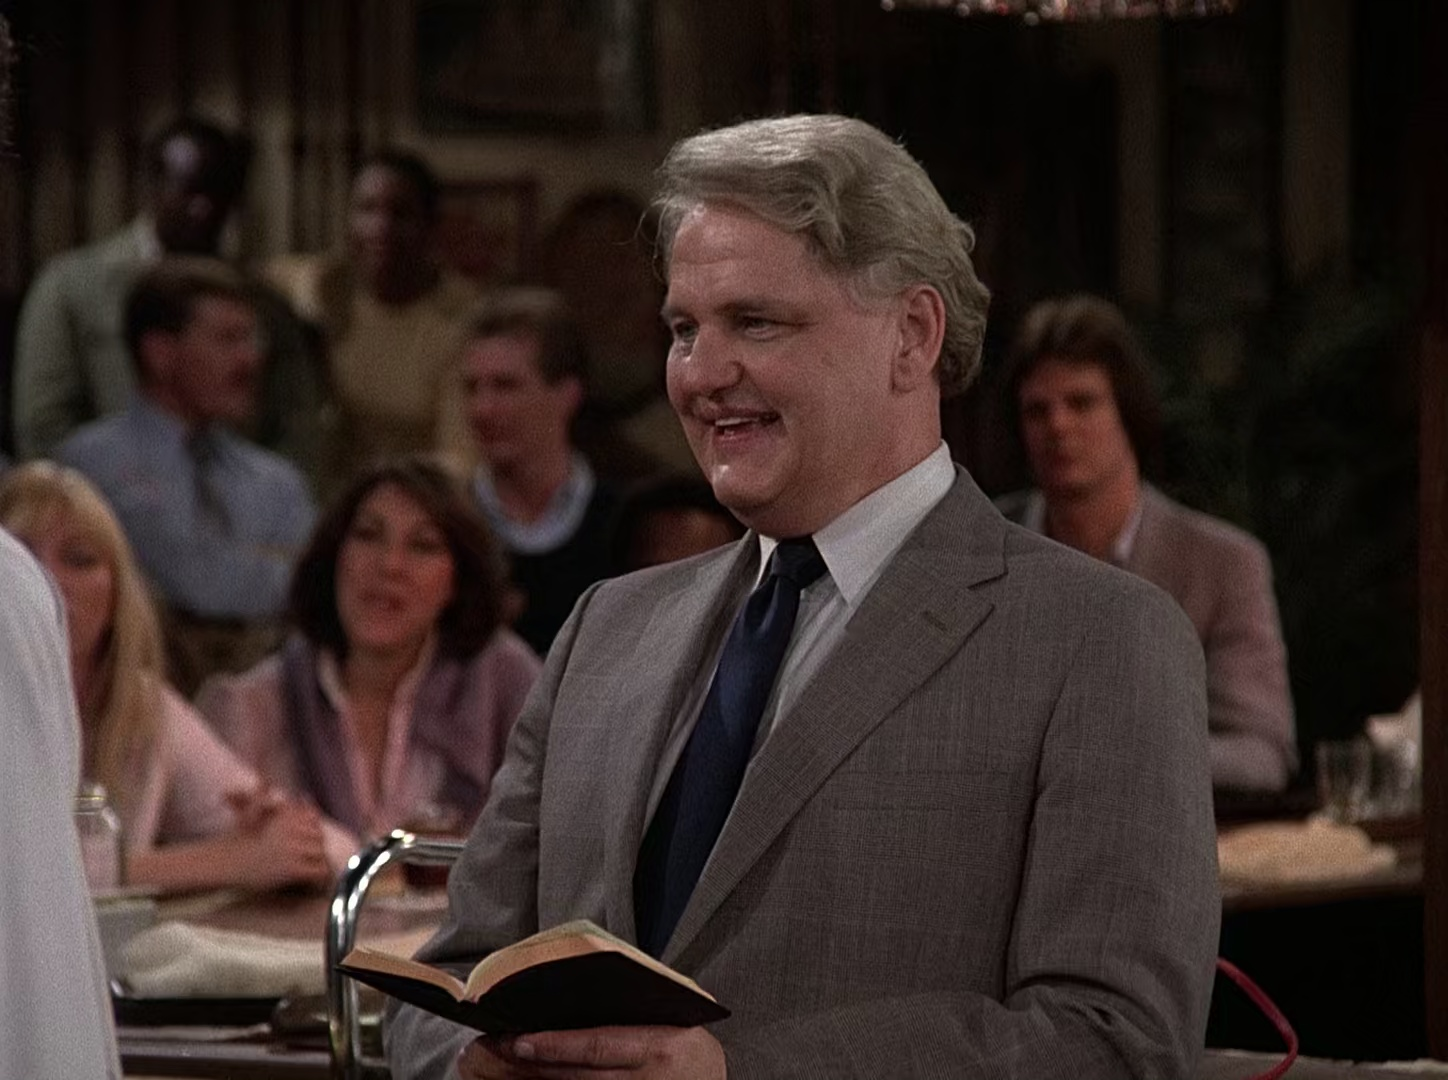

In [21]:
show_by_name('Cheers.S01E20.1080p.BluRay.x265-RARBG_24480.png')

### BatchFace

In [18]:
batchface_df = pd.read_csv('../test_results/batchface_new.csv', index_col=0)
batchface_df.head()

,x1,y1,x2,y2,width,height,area,confidence,face_num,img_width,img_height,pct_of_frame,name,duration
0,790.0,54.0,1134.0,506.0,344.0,452.0,155488.0,0.999380,0.0,1920.0,1080.0,0.074985,Frasier.S08E01-E02.And.the.Dish.Ran.Away.with....,2.816
1,1436.0,577.0,1991.0,1320.0,555.0,743.0,412365.0,0.925510,0.0,3840.0,1920.0,0.055931,Silo.S01E09.The.Getaway.2160p.ATVP.WEB-DL.DDP5...,7.298
2,269.0,78.0,369.0,218.0,100.0,140.0,14000.0,0.999830,0.0,640.0,480.0,0.045573,Will.&.Grace.S03E24.Sons.and.Lovers.Part.I.480...,3.148
3,552.0,74.0,619.0,229.0,67.0,155.0,10385.0,0.953337,1.0,640.0,480.0,0.033805,Will.&.Grace.S03E24.Sons.and.Lovers.Part.I.480...,3.148
4,346.0,201.0,773.0,819.0,427.0,618.0,263886.0,0.999895,0.0,1920.0,1080.0,0.127260,Suits.S03E05.1080p.BluRay.x265-RARBG_40416.png,0.140


In [19]:
batch_status = accuracy(batchface_df, faces)
show_heatmap(batch_status)

In [ ]:
batch_status[batch_status['status']=='fp'][['name', 'face_num', 'confidence']]

,name,face_num,confidence
4,Billions.S01E10.1080p.BluRay.x265-RARBG_51504.png,2,0.960874
8,Billions.S02E07.1080p.BluRay.x265-RARBG_39816.png,1,0.526186
17,Billions.S04E05.1080p.WEBRip.x265-RARBG_37200.png,1,0.820354
28,Billions.S05E08.1080p.WEBRip.x265-RARBG_72000.png,1,0.569218
40,Carnivale.S01E10.1080p.WEBRip.10Bit.EAC3.H265-...,1,0.653868
...,...,...,...
2459,Will.&.Grace.S11E06.Performance.Anxiety.1080p....,14,0.589030
2462,Will.&.Grace.S11E08.Lies.&.Whispers.1080p.Web....,2,0.995879
2463,Will.&.Grace.S11E08.Lies.&.Whispers.1080p.Web....,3,0.591159
2467,Will.&.Grace.S11E08.Lies.&.Whispers.1080p.Web....,3,0.911256


In [ ]:
temp = batch_status[batch_status['status']=='fp']['name'].unique().tolist()
print(len(temp))
[print(x) for x in temp]

349
Billions.S01E10.1080p.BluRay.x265-RARBG_51504.png
Billions.S02E07.1080p.BluRay.x265-RARBG_39816.png
Billions.S04E05.1080p.WEBRip.x265-RARBG_37200.png
Billions.S05E08.1080p.WEBRip.x265-RARBG_72000.png
Carnivale.S01E10.1080p.WEBRip.10Bit.EAC3.H265-d3g_11904.png
Carnivale.S02E03.1080p.WEBRip.10Bit.EAC3.H265-d3g_35616.png
Carnivale.S02E04.1080p.WEBRip.10Bit.EAC3.H265-d3g_32664.png
Carnivale.S02E09.1080p.WEBRip.10Bit.EAC3.H265-d3g_60816.png
Cheers.S01E02.1080p.BluRay.x265-RARBG_11184.png
Cheers.S01E09.1080p.BluRay.x265-RARBG_29496.png
Cheers.S01E22.1080p.BluRay.x265-RARBG_25800.png
Cheers.S02E06.1080p.BluRay.x265-RARBG_24360.png
Cheers.S02E20.1080p.BluRay.x265-RARBG_15768.png
Cheers.S03E01.1080p.BluRay.x265-RARBG_32352.png
Cheers.S03E05.1080p.BluRay.x265-RARBG_33960.png
Cheers.S03E05.1080p.BluRay.x265-RARBG_34080.png
Cheers.S03E06.1080p.BluRay.x265-RARBG_31200.png
Cheers.S03E07.1080p.BluRay.x265-RARBG_16704.png
Cheers.S03E07.1080p.BluRay.x265-RARBG_25800.png
Cheers.S03E18.1080p.BluRay.x

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

### RetinaCustom

In [43]:
custom_df = pd.read_csv('../test_results/retina_custom_new.csv', index_col=0)
custom_status = accuracy(custom_df, faces)
show_heatmap(custom_status)

#### Top 1 Accuracy

In [46]:
custom_top1 = top1_accuracy(custom_df, faces)
show_heatmap(custom_top1)

### RetinaTorch

In [44]:
retina_torch = pd.read_csv('../test_results/retina_torch_new.csv', index_col=0)
retina_torch.head()


,x1,y1,x2,y2,width,height,area,confidence,face_num,img_width,img_height,pct_of_frame,name,duration
0,526,30,748,323,222,293,65046,0.999685,0,1920,1080,0.031369,Frasier.S08E01-E02.And.the.Dish.Ran.Away.with....,1.019
1,502,108,756,501,254,393,99822,0.999478,0,3840,1920,0.013539,Silo.S01E09.The.Getaway.2160p.ATVP.WEB-DL.DDP5...,0.298
2,405,119,552,323,147,204,29988,0.998785,0,640,480,0.097617,Will.&.Grace.S03E24.Sons.and.Lovers.Part.I.480...,0.182
3,834,120,938,335,104,215,22360,0.986539,1,640,480,0.072786,Will.&.Grace.S03E24.Sons.and.Lovers.Part.I.480...,0.182
4,217,127,506,523,289,396,114444,0.999983,0,1920,1080,0.055191,Suits.S03E05.1080p.BluRay.x265-RARBG_40416.png,0.197


In [45]:
retina_torch_status = accuracy(retina_torch, faces)
show_heatmap(retina_torch_status)

IndexError: single positional indexer is out-of-bounds

### MTCNN

In [49]:
mtcnn_df = pd.read_csv('../test_results/mtcnn.csv', index_col=0)
mtcnn_df.head()

,x1,y1,x2,y2,width,height,area,confidence,face_num,img_width,img_height,pct_of_frame,name,duration
0,793.0,60.0,1147.0,533.0,354.0,473.0,167442.0,533.892578,0.0,1920.0,1080.0,0.080749,Frasier.S08E01-E02.And.the.Dish.Ran.Away.with....,0.527
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Silo.S01E09.The.Getaway.2160p.ATVP.WEB-DL.DDP5...,0.318
2,270.0,79.0,369.0,209.0,99.0,130.0,12870.0,209.161331,0.0,640.0,480.0,0.041895,Will.&.Grace.S03E24.Sons.and.Lovers.Part.I.480...,0.060
3,322.0,193.0,805.0,822.0,483.0,629.0,303807.0,822.576172,0.0,1920.0,1080.0,0.146512,Suits.S03E05.1080p.BluRay.x265-RARBG_40416.png,0.101
4,410.0,86.0,460.0,155.0,50.0,69.0,3450.0,155.257019,0.0,640.0,480.0,0.011230,Will.&.Grace.S05E24.Season.Finale.480p.Web.h26...,0.050


In [50]:
torch_status = accuracy(mtcnn_df, faces)
show_heatmap(torch_status)

#### Top 1 Accuracy

In [51]:
mtcnn_top1 = top1_accuracy(mtcnn_df, faces)
show_heatmap(mtcnn_top1)

### OpenCV

In [13]:
cv_df = pd.read_csv('../test_results/cv_new.csv', index_col=0)
cv_df.head()

,x1,y1,x2,y2,img_width,img_height,width,height,area,pct_of_frame,confidence,face_num,name,duration
0,758.0,43.0,1146.0,500.0,1920.0,1080.0,388.0,457.0,177316.0,0.085511,0.948475,0.0,Frasier.S08E01-E02.And.the.Dish.Ran.Away.with....,0.214
1,1317.0,280.0,2071.0,1429.0,3840.0,1920.0,754.0,1149.0,866346.0,0.117506,0.673572,0.0,Silo.S01E09.The.Getaway.2160p.ATVP.WEB-DL.DDP5...,0.114
2,269.0,75.0,369.0,216.0,640.0,480.0,100.0,141.0,14100.0,0.045898,0.999995,0.0,Will.&.Grace.S03E24.Sons.and.Lovers.Part.I.480...,0.008
3,310.0,156.0,809.0,816.0,1920.0,1080.0,499.0,660.0,329340.0,0.158825,0.998357,0.0,Suits.S03E05.1080p.BluRay.x265-RARBG_40416.png,0.036
4,408.0,80.0,464.0,158.0,640.0,480.0,56.0,78.0,4368.0,0.014219,0.988873,0.0,Will.&.Grace.S05E24.Season.Finale.480p.Web.h26...,0.007


In [14]:
cv_status = accuracy(cv_df, faces)
show_heatmap(cv_status)

#### Top 1 Accuracy

In [15]:
cv_status['actual'].value_counts()

actual
1    2945
0      24
Name: count, dtype: int64

#### Precision-Recall Curve

In [14]:
fig = plot_pr_curve(cv_status)
fig.show()

In [17]:
cv_status[cv_status['status']=='fn']['name'].unique().tolist()

['Billions.S01E10.1080p.BluRay.x265-RARBG_51504.png',
 'Billions.S04E02.1080p.WEBRip.x265-RARBG_52416.png',
 'Billions.S04E06.1080p.WEBRip.x265-RARBG_01344.png',
 'Billions.S04E10.1080p.WEBRip.x265-RARBG_15288.png',
 'Billions.S06E08.1080p.WEBRip.x265-RARBG_27264.png',
 'Billions.S06E10.1080p.WEBRip.x265-RARBG_73680.png',
 'Billions.S06E12.1080p.WEBRip.x265-RARBG_10632.png',
 'Carnivale.S02E03.1080p.WEBRip.10Bit.EAC3.H265-d3g_35616.png',
 'Carnivale.S02E04.1080p.WEBRip.10Bit.EAC3.H265-d3g_20880.png',
 'Cheers.S01E02.1080p.BluRay.x265-RARBG_11184.png',
 'Cheers.S01E07.1080p.BluRay.x265-RARBG_09000.png',
 'Cheers.S01E09.1080p.BluRay.x265-RARBG_18408.png',
 'Cheers.S01E09.1080p.BluRay.x265-RARBG_29496.png',
 'Cheers.S01E20.1080p.BluRay.x265-RARBG_24480.png',
 'Cheers.S02E01.1080p.BluRay.x265-RARBG_07056.png',
 'Cheers.S02E19.1080p.BluRay.x265-RARBG_31392.png',
 'Cheers.S02E20.1080p.BluRay.x265-RARBG_15768.png',
 'Cheers.S03E03.1080p.BluRay.x265-RARBG_09624.png',
 'Cheers.S03E03.1080p.BluR

### Yunet

In [25]:
yunet = pd.read_csv('../test_results/yunet_new.csv', index_col=0)
yunet.head()

,x1,y1,x2,y2,face_num,landmarks,confidence,model,img_width,img_height,face_width,face_height,area,pct_of_frame,name,width,height,duration
0,717.0,90.0,1165.0,500.0,0.0,"{'left_eye': [149, 66], 'right_eye': [172, 67]...",0.857385,yunet,1920.0,1080.0,448.000000,410.4,183859.200000,0.088667,Frasier.S08E01-E02.And.the.Dish.Ran.Away.with....,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Silo.S01E09.The.Getaway.2160p.ATVP.WEB-DL.DDP5...,NaN,NaN,NaN
2,265.0,82.0,371.0,208.0,0.0,"{'left_eye': [142, 83], 'right_eye': [167, 83]...",0.912535,yunet,640.0,480.0,106.666667,126.4,13482.666667,0.043889,Will.&.Grace.S03E24.Sons.and.Lovers.Part.I.480...,NaN,NaN,NaN
3,546.0,61.0,649.0,219.0,1.0,"{'left_eye': [267, 75], 'right_eye': [273, 76]...",0.702972,yunet,640.0,480.0,102.400000,158.4,16220.160000,0.052800,Will.&.Grace.S03E24.Sons.and.Lovers.Part.I.480...,NaN,NaN,NaN
4,198.0,166.0,260.0,226.0,2.0,"{'left_eye': [100, 119], 'right_eye': [108, 11...",0.549671,yunet,640.0,480.0,61.866667,59.2,3662.506667,0.011922,Will.&.Grace.S03E24.Sons.and.Lovers.Part.I.480...,NaN,NaN,NaN


In [44]:
yunet_status = accuracy(yunet, faces)
fig = show_heatmap(yunet_status, title='Overall Accuracy')
fig.write_image('../heatmaps/yunet.png')
fig.show()

In [46]:
yunet_top1 = top1_accuracy(yunet, faces)
fig = show_heatmap(yunet_top1, title='Top 1 Accuracy')
fig.write_image('../heatmaps/yunet_top1.png')
fig.show()

In [47]:
fig = px.histogram(yunet_status, x='pct_of_frame', color='status', histnorm='percent')
fig.show()

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['name', 'status'] but received: pct_of_frame

### SCRFD

In [15]:
scrfd = pd.read_csv('../test_results/scrfd.csv', index_col=0)
scrfd.head()

,x1,y1,x2,y2,width,height,area,confidence,face_num,img_width,img_height,pct_of_frame,name,duration
0,999.0,140.0,1538.0,919.0,539.0,779.0,419881.0,0.866526,0.0,1920.0,1080.0,0.202489,The.X-Files.S02E18.Fearful.Symmetry.1080p.BluR...,0.120
1,206.0,151.0,606.0,865.0,400.0,714.0,285600.0,0.691233,1.0,1920.0,1080.0,0.137731,The.X-Files.S02E18.Fearful.Symmetry.1080p.BluR...,0.120
2,148.0,118.0,431.0,570.0,283.0,452.0,127916.0,0.894302,0.0,1920.0,1080.0,0.061688,Seinfeld.S06E08.1080p.WEBRip.x265-RARBG_15528.png,0.118
3,1433.0,211.0,1720.0,633.0,287.0,422.0,121114.0,0.852575,1.0,1920.0,1080.0,0.058408,Seinfeld.S06E08.1080p.WEBRip.x265-RARBG_15528.png,0.118
4,1158.0,272.0,1497.0,814.0,339.0,542.0,183738.0,0.733005,0.0,1920.0,1080.0,0.088608,The.X-Files.S01E01.Pilot.1080p.BluRay.10Bit.Dt...,0.113


In [16]:
scrfd_status = accuracy(scrfd, faces)
fig = show_heatmap(scrfd_status, title='Overall Accuracy')
fig.write_image('../heatmaps/scrfd.png')
fig.show()

In [17]:
scrfd_top1 = top1_accuracy(scrfd, faces)
fig = show_heatmap(scrfd_top1, title='Top 1 Accuracy')
fig.write_image('../heatmaps/scrfd_top1.png')
fig.show()

In [29]:
scrfd_status[scrfd_status['status'] == 'fp']

,name,status,pct_of_frame
2,Billions.S01E10.1080p.BluRay.x265-RARBG_51504.png,fp,0.012795
3,Billions.S01E10.1080p.BluRay.x265-RARBG_51504.png,fp,0.008805
4,Billions.S01E10.1080p.BluRay.x265-RARBG_51504.png,fp,0.000137
18,Billions.S04E07.1080p.WEBRip.x265-RARBG_74328.png,fp,0.025208
19,Billions.S04E07.1080p.WEBRip.x265-RARBG_74328.png,fp,0.181866
...,...,...,...
2219,Cheers.S09E21.1080p.BluRay.x265-RARBG_01776.png,fp,0.001254
2220,Cheers.S09E21.1080p.BluRay.x265-RARBG_01776.png,fp,0.005559
2221,Cheers.S09E21.1080p.BluRay.x265-RARBG_01776.png,fp,0.002132
2222,Cheers.S09E21.1080p.BluRay.x265-RARBG_01776.png,fp,0.001865


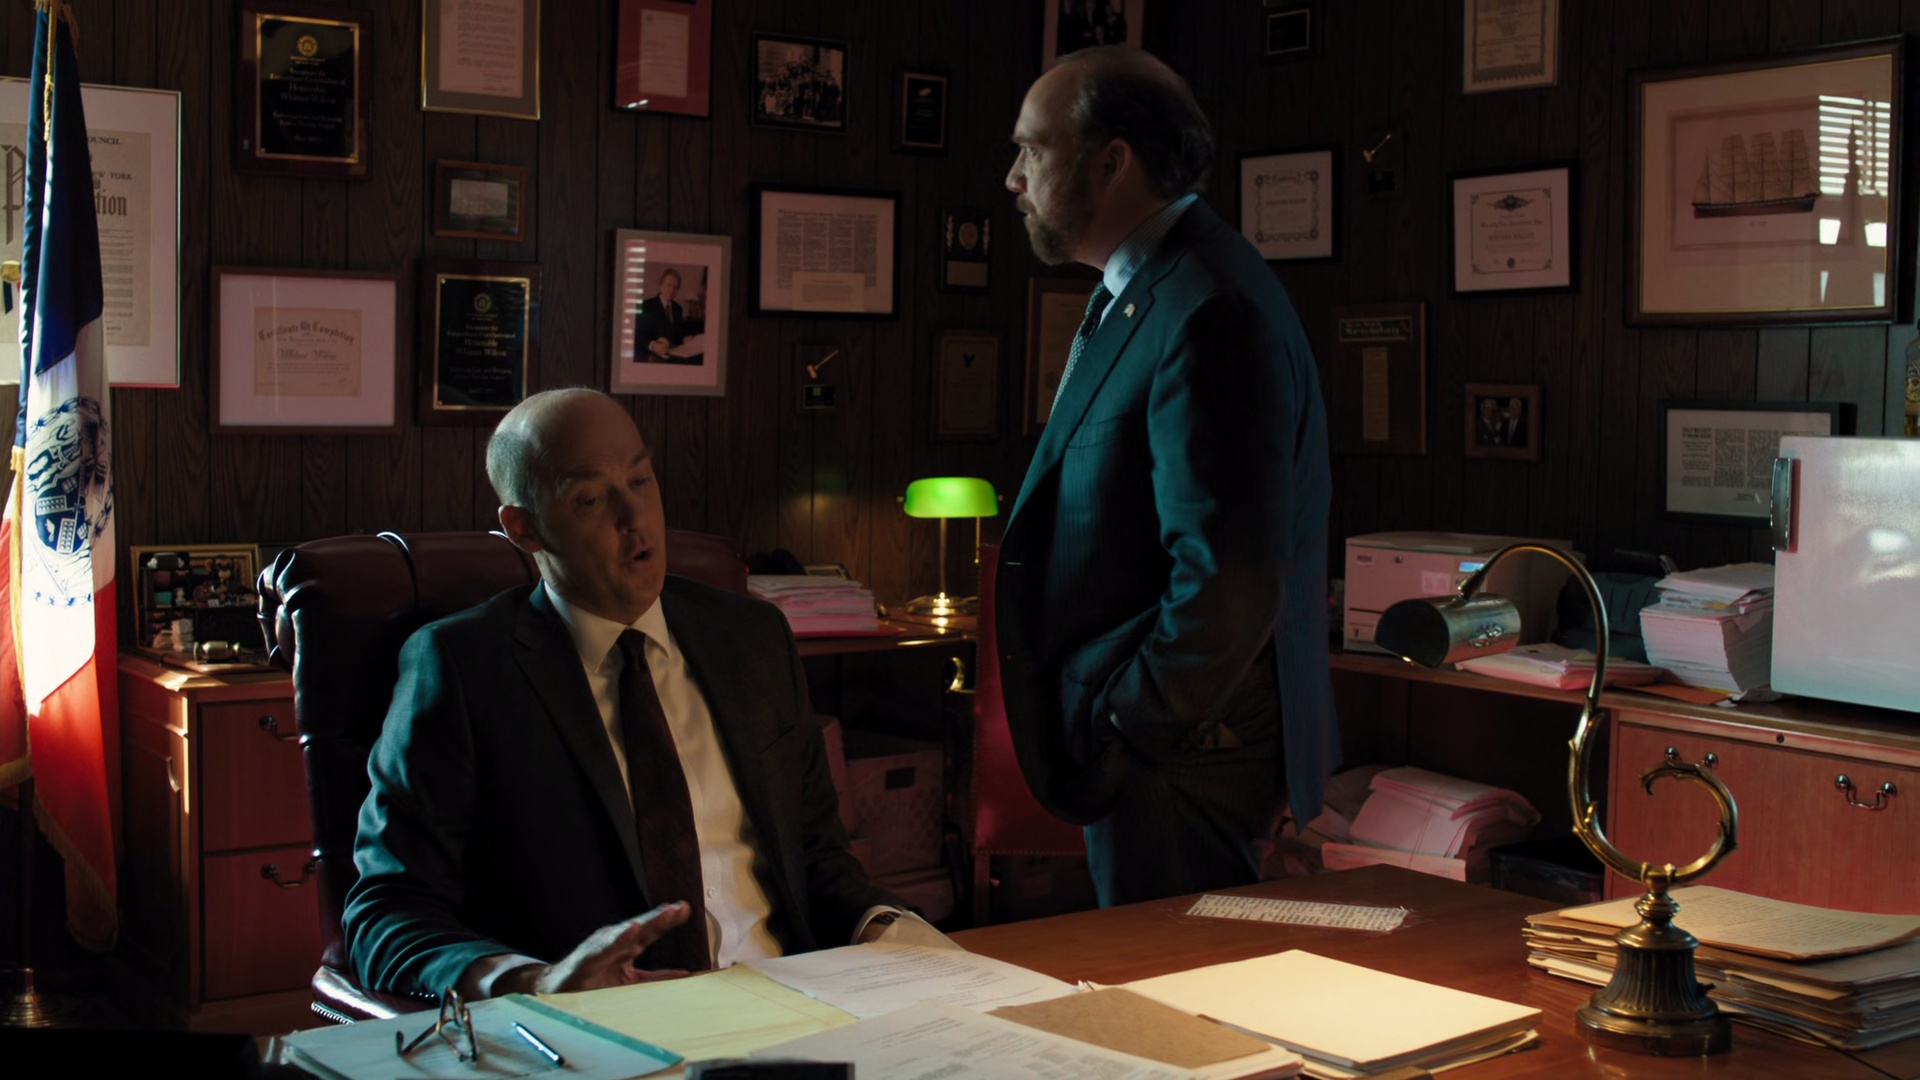

In [31]:
show_by_name('Billions.S01E10.1080p.BluRay.x265-RARBG_51504.png')

In [27]:
scrfd['duration'].mean()

0.10601544220870379

In [28]:
retina_df['duration'].mean()

0.16564180522565317